    This notebook performs several steps for predicting forest fire occurrences based on various variables. It starts by importing necessary libraries such as NumPy, Pandas, Matplotlib, Seaborn.  The code then reads three CSV files containing the forest fire dataset and combines them into a single DataFrame. It performs data preprocessing steps by handling missing values, renaming columns, and dropping duplicates. The code further transforms the target variable by converting it into numeric values. The dataset is split into training and testing sets. A XGBClassifier is trained on the training data. Finally, the code evaluates the trained model by predicting classes for the test data, calculating the accuracy score, and generating a classification report and a heatmap of the confusion matrix. These steps provide insights into the forest fire prediction based on the given variables, allowing for analysis and assessment of the model's performance.

# Notebook's content
1. [Loading Data](#0)
2. [Pre-processing](#1)
3. [XGBClassifier](#2)
3. [Model Evaluation](#3)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import random
import tempfile
import gc
gc.collect()

0

<a id="0"></a> <br>
# Loading Data

In [2]:
df1 = pd.read_csv('/kaggle/input/algerian-forest-fires-dataset-updatecsv/Algerian_forest_fires_dataset_UPDATE.csv')
df2 = pd.read_csv('/kaggle/input/algerian-forest-fires-dataset-updatecsv/Bejaia Region ForestFire Dataset.csv')
df3 = pd.read_csv('/kaggle/input/algerian-forest-fires-dataset-updatecsv/Sidi-Bel Abbes Region ForestFire Dataset.csv')
df=pd.concat([df1, df2, df3])
df.rename(columns={'Classes  ': 'Classes'}, inplace=True)

In [3]:
df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,1,6,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2,not fire
1,2,6,2012,30,73,13,4.0,55.7,2.7,7.8,0.6,2.9,0.2,not fire
2,3,6,2012,29,80,14,2.0,48.7,2.2,7.6,0.3,2.6,0.1,not fire
3,4,6,2012,30,64,14,0.0,79.4,5.2,15.4,2.2,5.6,1,not fire
4,5,6,2012,32,60,14,0.2,77.1,6.0,17.6,1.8,6.5,0.9,not fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,26,9,2012,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,fire
118,27,9,2012,28,87,15,4.4,41.1,6.5,8,0.1,6.2,0,not fire
119,28,9,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
120,29,9,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire


<a id="1"></a> <br>
# Pre-processing


In [4]:
df = df.fillna(df.median())
df = df.fillna(df.mode().iloc[0])
df = df.drop_duplicates()


/tmp/ipykernel_23/2694430884.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.median())


In [5]:
if df['Classes'].dtype == 'object':
    df['Classes'] = df['Classes'].str.strip().str.lower().map({'fire': 1, 'not fire': 0})


In [6]:
df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,1,6,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2,0
1,2,6,2012,30,73,13,4.0,55.7,2.7,7.8,0.6,2.9,0.2,0
2,3,6,2012,29,80,14,2.0,48.7,2.2,7.6,0.3,2.6,0.1,0
3,4,6,2012,30,64,14,0.0,79.4,5.2,15.4,2.2,5.6,1,0
4,5,6,2012,32,60,14,0.2,77.1,6.0,17.6,1.8,6.5,0.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,26,9,2012,31,54,11,0.0,82.0,6.0,16.3,2.5,6.2,1.7,0
118,27,9,2012,31,66,11,0.0,85.7,8.3,24.9,4.0,9.0,4.1,1
119,28,9,2012,32,47,14,0.7,77.5,7.1,8.8,1.8,6.8,0.9,0
120,29,9,2012,26,80,16,1.8,47.4,2.9,7.7,0.3,3.0,0.1,0


In [7]:
df['DC'] = pd.to_numeric(df['DC'], errors='coerce')
df['FWI'] = pd.to_numeric(df['FWI'], errors='coerce')

In [8]:
corr_matrix = df.corr()

# Find highly correlated features
highly_correlated_features = []
threshold = 0.7  # Adjust the threshold as desired

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            # Append the correlated feature pair
            feature_i = corr_matrix.columns[i]
            feature_j = corr_matrix.columns[j]
            correlation = corr_matrix.iloc[i, j]
            highly_correlated_features.append((feature_i, feature_j, correlation))

# Print the highly correlated features
for feature_i, feature_j, correlation in highly_correlated_features:
    print(f"{feature_i} and {feature_j} are highly correlated: {correlation}")

FFMC and ISI are highly correlated: 0.7397300183266767
FFMC and Classes are highly correlated: 0.7701140591063843
DMC and DC are highly correlated: 0.8759246606759631
DMC and BUI are highly correlated: 0.9820732709504015
DMC and FWI are highly correlated: 0.8758641588191534
DC and BUI are highly correlated: 0.9419884631009658
DC and FWI are highly correlated: 0.7395205557052653
ISI and FWI are highly correlated: 0.9228949343157856
ISI and Classes are highly correlated: 0.7355108835495274
BUI and FWI are highly correlated: 0.857973095896425
FWI and Classes are highly correlated: 0.7192161486674151


In [9]:
#Keeping only the most important features for xgb classifier
selected_columns = ['DC','ISI','Classes']  

df = df[selected_columns].copy()


In [10]:

X = df.drop(['Classes'], axis=1)
y = df['Classes']

In [11]:
from sklearn.model_selection import train_test_split


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<a id="2"></a> <br>
# XGBClassifier


In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create the individual classifiers

model = XGBClassifier(random_state=42)



# Fit the Voting Classifier on the training data
model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

<a id="3"></a> <br>
# Model Evaluation


In [13]:
from sklearn.metrics import accuracy_score

# Predict classes on the test data
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.972972972972973


In [14]:
from sklearn.metrics import classification_report


# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       1.00      0.96      0.98        45

    accuracy                           0.97        74
   macro avg       0.97      0.98      0.97        74
weighted avg       0.97      0.97      0.97        74



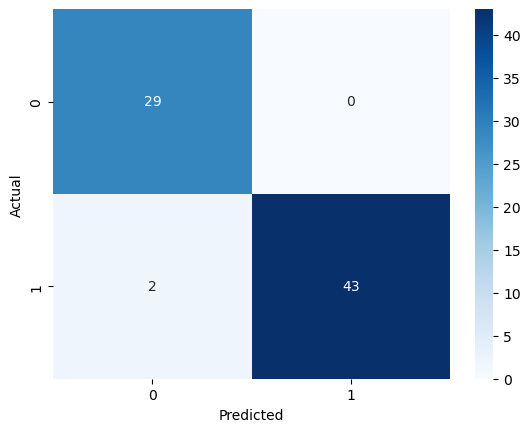

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ISI: 0.9928349852561951
DC: 0.007164989598095417


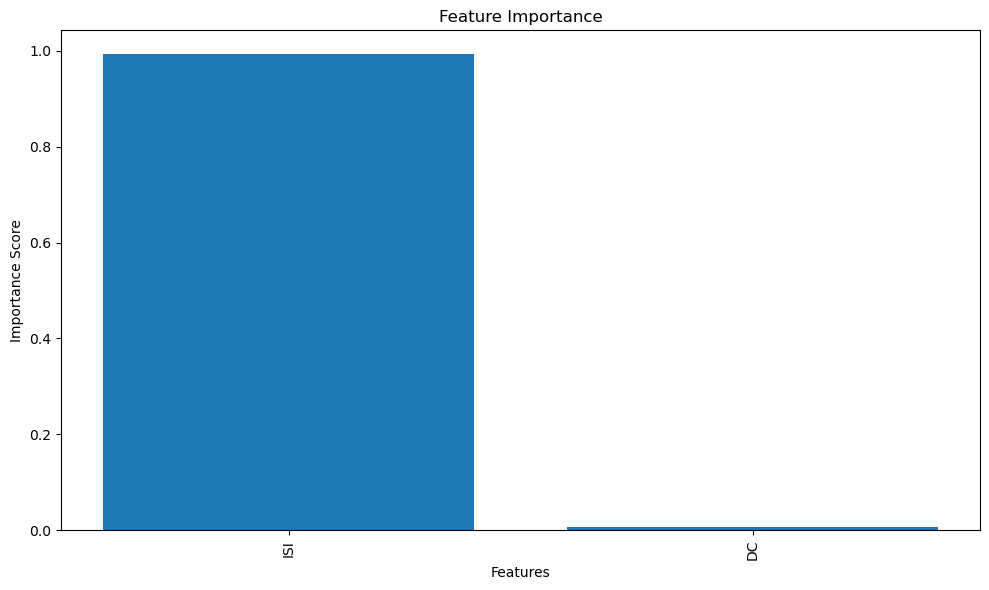

In [16]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already trained an XGBoost model and assigned it to the variable 'model'
# If not, you need to train an XGBoost model before running the code below

# Retrieve feature importance scores from the trained model
importance_scores = model.feature_importances_

# Initialize feature names variable
feature_names = None

# Check if feature names are available
if hasattr(model, 'feature_names_'):
    feature_names = model.feature_names_
else:
    # Retrieve feature names from the input data structure used for training
    if isinstance(model.get_booster().get_score(importance_type='weight'), dict):
        # If you trained the model using a pandas DataFrame
        sorted_features = sorted(model.get_booster().get_score(importance_type='weight').items(), key=lambda x: x[1], reverse=True)
        feature_names = [f[0] for f in sorted_features]

# Sort the feature importance scores and feature names in descending order
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_scores = importance_scores[sorted_indices]
sorted_names = [feature_names[i] if feature_names and i < len(feature_names) else f'Feature {i}' for i in sorted_indices]

# Print the feature importance scores and names
for score, name in zip(sorted_scores, sorted_names):
    print(f"{name}: {score}")

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_scores)), sorted_scores, tick_label=sorted_names)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()
